In [1]:
#!pip uninstall -y dgl
#!pip install dgl --pre

# DGL, a tutorial in MPNN
In this notebook, we shall implement a simple example of the Karate club, which is basically the MNIST of GNN.

## Karate Club Problem
In the early 1970s karate club was observed for two years. The management of club had issues with the instructor, Mr. Hi. A unilateral increase in price of lessons, resulted in firing of Mr. Hi by the president. Supports of Mr. Hi resigned and started a new club, headed by Mr. Hi. 
A social network, representing relationship amongst members prior to the split was reconstructed based on archives and information. This network can help predict club membership decision by the members before the split.
In this notebook, we intend to predict members decisions based on the information of the karate club dataset.

In [156]:
import networkx as nx
import matplotlib.pyplot as plt
import dgl
import numpy as np
import torch
dgl.__version__

'0.4.3'

In [157]:
import sys
sys.path.append('./supportingexamples/')
import examples
import dgl.data

## Drawing the graph of the problem
Below are drawings of the karate club interaction graph. We can observe that the club connections are centered around node 0 and node 33. I have used to different layouts. First the cycle layout that is similar to the graph in the original paper from the 1970s and then Kamada Kawai Layout, which gives us a more expressive graph. I have load the data using ```python networkx.karate_club_graph```

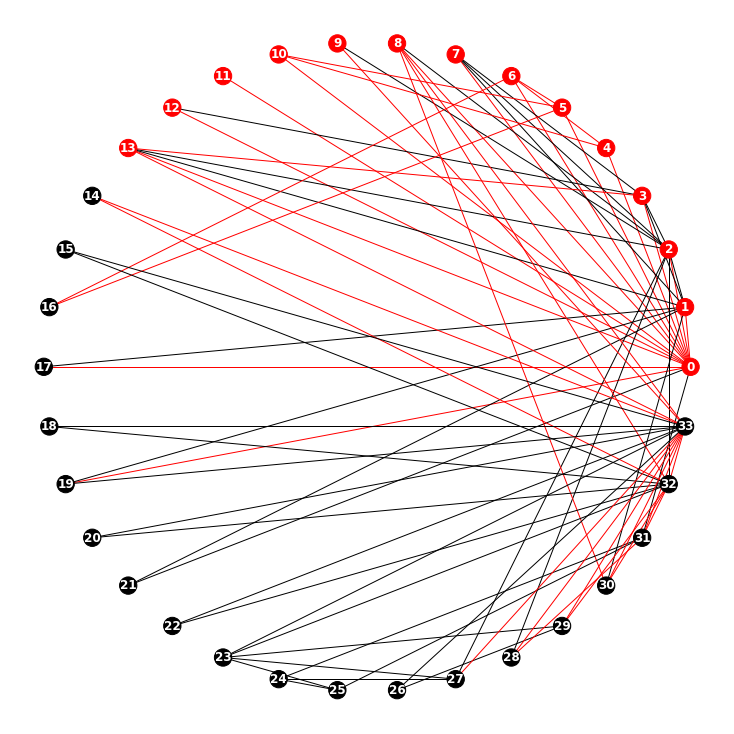

In [4]:
G = nx.karate_club_graph()
examples.draw_interaction_graph(G=G, pos='c')

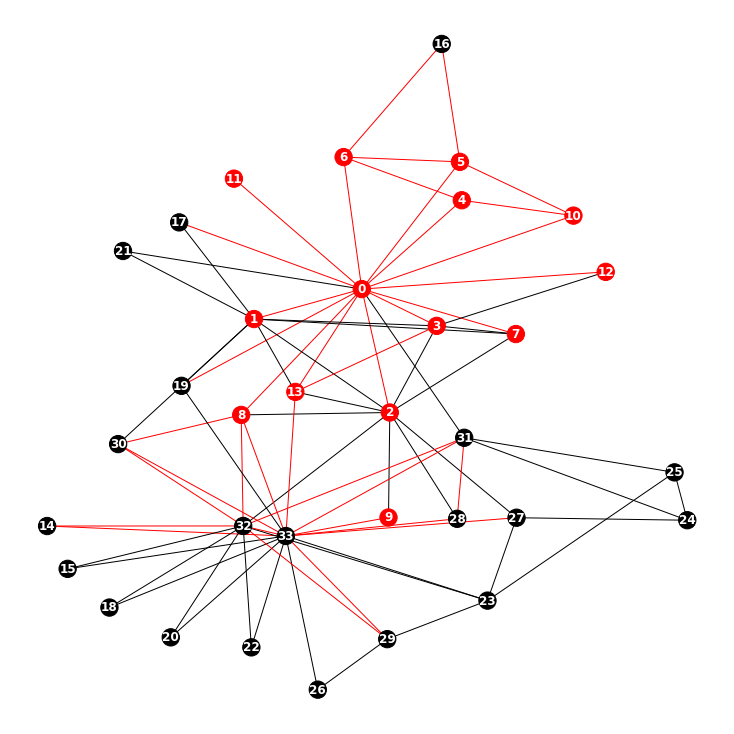

In [5]:
examples.draw_interaction_graph(G=G)

## Defining the graph
Since this notebook is all about using DGL to train the karate club network, let us create a DGL graph, using ```dgl.data.karate.KarateClub()``` . 
***note:*** *Please note that you need at least dgl version ```0.4.2``` for this to work. Older version do have a bug and return error. In oder to check your dgl version, please run ```dgl.__version__```.*

```dgl.data.karate.KarateClub()``` returns an object with two properties: data, and label. 'data' object is a python list with only one element of type ```dgl.DGLGraph```. data includes node labels. Node labels are either 1 or 0 with 1 indicating that the member, who is represented as a node, belongs to Mr. Hi's club.
'label' is a replica of ```KarateClub.data[0].nodes[:].data['label']```.


### ```dgl.data```
DGL has a data module that includes data utilities as well as a few datasets. An example of such datasets includes ```dgl.data.RedditDataset``` and ```G = dgl.data.karate.KarateClub```. In the following exercise we first use the KarateClub dataset from ```dgl.data```, but as you will see, all nodes are labeled, so we later create a new graph and assign only minimal number of labels to the nodes and try to learn the predict the labels using a 2-layer GCN.

In [66]:
# Creating a graph using karateclub dataset
G = dgl.data.karate.KarateClub()
G.data, G.data[0].nodes[:].data, G.data[0].nodes[:].data['label'], G.data[0].edges[:]

([DGLGraph(num_nodes=34, num_edges=156,
           ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64)}
           edata_schemes={})],
 {'label': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1])},
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 EdgeSpace(data={}))

We can observe that G is a list of one item that includes a ```dgl.DGLGraph``` object that contains:
- 34 nodes
- 156 edges
- Node data includes labels but no other features.
- Edges contain no data.

Next we will copy ```G.data[0]``` to ```G``` to make the code more clear.

In [67]:
G = G.data[0]

In the code below we can observe that the edges are presented as a tuple of two tensors. each edge $(v,w)$ is formed as a directed edge $t_{1}{[i]}\rightarrow t_2[i]$

In [8]:
G.nodes(), G.edges(), G.nodes[:].data

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 (tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
           1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
           3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
          13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
          21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
          27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
          31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]),
  tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
           3,  7, 13, 17, 19, 21, 30,  0,  1, 

In order to make the edges more friendly to human reader, next I will present them as tuples.
A closer inspection of the edge list shows that for each edge $(v,w)$, there also exists an edge $(w,v)$. This is because ```dgl.DGLGraph``` is always directed. an undirected graph is represented as two directed graphs where $\mathcal{G} = (V,E)\ and\ \forall (v, w) \in E \iff (w, v) \in E$


In [9]:
edges = [(int(v),int(w)) for (v,w) in zip(G.edges()[0], G.edges()[1])]
print("edge list:\n{}\n# of edges: {}".format(edges, len(edges)))

edge list:
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 0), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 0), (2, 1), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 0), (3, 1), (3, 2), (3, 7), (3, 12), (3, 13), (4, 0), (4, 6), (4, 10), (5, 0), (5, 6), (5, 10), (5, 16), (6, 0), (6, 4), (6, 5), (6, 16), (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (8, 30), (8, 32), (8, 33), (9, 2), (9, 33), (10, 0), (10, 4), (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (16, 5), (16, 6), (17, 0), (17, 1), (18, 32), (18, 33), (19, 0), (19, 1), (19, 33), (20, 32), (20, 33), (21, 0), (21, 1), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 23), (25, 24), (25, 31), (26, 29), (26, 33), (27, 2), (27, 23), (27, 24), (27, 33), (28, 2

We can remove the mirror edges and observe that the number of edges is halved.

In [10]:
ukcg_edges = []
for (v, w) in edges:
    if (w, v) not in ukcg_edges:
        ukcg_edges.append((v, w))
print("# of edges: {}".format(len(ukcg_edges)/len(edges)))

# of edges: 0.5


## Creating, labeling, and training the graph for Karate Club
### data preparation
In this section we
- create a new graph and add the edges from ```G``` to it.
- label the fist and the last node that represent the club president and the instructor.
- add features to our nodes in form identity matrix with dimension of $34 \times 34$.

In [11]:
# Creating and empty graph
H = dgl.DGLGraph() 
# Adding 34 nodes (0..33) to the graphs.
H.add_nodes(34)
# Adding edges from Graph G to H
H.add_edges(G.edges()[0], G.edges()[1])

H

DGLGraph(num_nodes=34, num_edges=156,
         ndata_schemes={}
         edata_schemes={})

In [12]:
# Crearing node feature matrix
H.ndata['features'] = np.eye(34)
H.ndata['features']

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64)

In [13]:
# Labling the data. Node 0 and 33 represent karate instructor and club president.
labeld_nodes = torch.tensor([0, 33])

# we make labels of the two figures differnet. it could be any an number.
labels = torch.tensor([0, 1])

## Creating a network
In order to create a GCN network, we would like to first create a GCN layer based on the MPNN framework, meaning that our layer should include: 1) a message sending component, and 2) an aggregation mechanism that performs a reduce operation.
The code below does just that.

### Building the MPNN layer
The code below provides a message function, a reduce function, and a sequence for sending and receiving a message.

Let us start from `forward`
```python
def forward(self, g, inputs):
    #...
    g.send(g.edges(), gcn_message)

    g.recv(g.nodes(), gcn_reduce)
    
    #...
```
As you can see method `forward` is composed of main components. `g.send` and `g.receive`. The combination of the two methods implements the MPNN framework.

#### sending messages:

As you might guess, `send` is a method of `dgl.DGLGraph`. It can take default value or you can pass a callable object to it. It also takes a single or a collection of edges, and applies the callable message function, `gcn_message` in this case, and returns messages that can be later retrieved from destination node's "mailbox" during the aggregation phase. If edges along which messages are to be sent are not passed to `DGLGraph.send`, the method defaults to `ALL` edges.

`send` takes `DGLGraph.edges()` and passes an instance of `dgl.udf.EdgeBatch` to the callable message function. the message function in this example, `gcn_message`, returns `EdgeBatch.src['h']`.

`dgl.udf.EdgeBatch` is a class that represents a batch of edges. Notable amongst properties of `dgl.udf.EdgeBatch` are:
- edges, edges of the current batch in form of (source, destination, and edge_id), 
- src, feature data of the source node, 
- dst, feature data of the destination node, and
- data, edge feature data.
All of the above properties are collection of type `dgl.utils.LazyDict`, which is in turn derives from `collections.abc.Mapping`



In this case of this simple example, `send` is implemented as:
```python
def gcn_message(edges):
    return {'msg' : edges.src['h']}
```
Network's forward pass, calculated the states, `h`, and adds that to the node data. In order to gain a better understanding of what is passed as a message in the network we can add print statements to `gcn_message`. 

In the code snippet below we print features of the source nodes.
```python     
print(list(edges.src['features']))
```
to `gcn_message` will output 
`
[tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), ...
`

and the below print statement prints the types of information that `edges.src` holds.

```python
    print(list(edges.src))
```
outputs items in the collection. In this case, the output is:

`
['features', 'h']
`

Finally, we can print the hidden states to investigate what exactly is passed as body of a message.
```python
    print(list(edges.src['h']))
```
is:
`
[tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 
 tensor([[ 0.3686,  0.7266],
        [ 0.1761,  0.5784],
        [ 0.4580,  0.4209],
        ...],
    [tensor([0.0000, 0.2411, 0.0000, 0.0000, 0.0259], grad_fn=<SelectBackward>),
    ...]
`
The print above is after running the training. Before training, as expected, the outcome of `print(list(edges.src['h']))` is the same as `print(list(edges.src['features']))` since no computation has yet taken place.

*The source for this example is taken from [DGL Documentation](https://docs.dgl.ai/en/0.4.x/tutorials/basics/1_first.html)

#### receiving messages:
Receiving messages is composed of:
- retrieving messages from all or a selected group of nodes, and 
- performing a reduce operation in order to aggregate message information. 

As messages are computed during the send process, they are stored in an instance of ```dgl.udf.NodeBatch```. During the reduce process we access the messages by retrieving them from `NodeBatch.mailbox` property, which returns the local variable `NodeBatch.__msgs`. `mailbox` is again a dictionary with *keys* of type `str` and *values* of type `tensor`.  

Analogous to `EdgeBatch`, that is used to request a batch of edges, `NodeBatch` is a class that can request a batch of nodes.
`dgl.NodeBatch`'s notable properties include:
- nodes, that contains node ides of a graph,
- data, a dictionary that contains node features, and
- msgs, a dictionary that contains messages that are related to a node.

Send stage in `GCLLayer.forward` is called though the following code snippet.
```python
def forward(self, g, inputs):
    #...
    g.send(g.edges(), gcn_message)

    g.recv(g.nodes(), gcn_reduce)
    
    #...
```

Similar to send, receive, send a list of nodes and a callable function to `DGLGraph.recv`. `recv` updates node features for all nodes that are passed to the callable reduce function for all nodes with incoming messages. If no node list in indicated, then, node list defaults to `ALL`.

In this simple example, `gcn_reduce` takes a node list and performs a sum over all messages in the node inbox as they were calculated in the send step and updates node features with the new values for all nodes with incoming arcs.

```python
def gcn_reduce(nodes):
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}
```

To understand how messages in the inbox look like, we can print them by adding:
```python
    print(list(nodes.mailbox['msg'][0]))
```
to `gcn_reduce`.
The outcome is similar in shape to `EdgeBatch.src['h']`

`
[tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), ...]
[tensor([0.7073, 0.9992, 0.0000, 0.0000, 0.1953], grad_fn=<SelectBackward>), ...]
`


In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [139]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    #print(list(edges.src['h']))
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    #print(list(nodes.mailbox['msg'][0]))
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges 
        g.send(g.edges(), gcn_message)
        
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)

        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

## Creating the Network
Now that we have created the GNCLayer, we can stack the layers and create a 2-layer GCN network. The network:
- Takes an input with dimensions of the input data. In the case of this example, 34.
- Calculates the hidden state with an output dimension it has been given as a variable by passing the input through a `GCNLayer`.
```python
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        ...
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        ...
    ...
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        ...
```
- Passes the state of the network through ReLU activation.

```python
    def forward(self, g, inputs):
        ...
        h = torch.relu(h)

```
- Passes the hidden states to another `GCNLayer`, and outputs a tensor of the shape it has been provided as input parameter. In this case of this example, we would like to make a decision as whether a club member moved to the instructor's new club, or stays with the current club, so we have chosen two output nodes. Later we pass the output layer to a softmax to create a binary output.
```python
    def forward(self, g, inputs):
        ...
        h = self.gcn2(g, h)
        return h
```

The network has the following architecture and is coded in the next cell.

```python
net = GCN(34, 5, 2)
```
`
GCN(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=34, out_features=5, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=5, out_features=2, bias=True)
  )
)
`


In [148]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

## Preparing the Data
Now that the network is defined, we can start creating training data as well as train the network. For this example:
- we create inputs of on-hot encoding of size $34 \times 34$. As you recall H is the karate club graph we created based on `dgl.data.karate.KarateClub`. We also note that `len(H.nodes())` equals 34.
```python
inputs = torch.eye(len(H.nodes()))
```
- We then label the data with associating $[0, 1]$ to $[0, 33]$ to ensure labels for the instructor and president are different.
```python
labeled_nodes = torch.tensor([0, 33])  
labels = torch.tensor([0, 1]) 
```
- We use the same identity matrix to defined node feathers.
```python
H.ndata['features'] = torch.eye(34)
```

In [149]:
inputs = torch.eye(len(H.nodes()))
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different
H.ndata['features'] = torch.eye(34)

## The Forward Path
We are now ready to compute the forward path using our network simply by calling `net` and passing a graph and your inputs. If the input shape is in agreement with the parameters you have instantiated your network with, it should run.

```python
gnet = net(H, inputs)
```
You can observe that the output is of size $[34, 2]$, which is consistent with definition of our networks that accepts input size of 34, creates a hidden layer of size 5, and outputs 2.

***Note:*** *if you intend to print your graph data during send and receive, they will be printed here when you compute the forward path.*

In [153]:
gnet = net(H, inputs)
gnet[:5], gnet.shape

(tensor([[-0.1767, -0.1342],
         [-0.2812,  0.2132],
         [-0.5364,  0.7362],
         [-0.0589,  0.1992],
         [ 0.1897, -0.2406]], grad_fn=<SliceBackward>), torch.Size([34, 2]))

In [154]:
labeled_nodes = torch.tensor([0, 33])
labels, labeled_nodes

(tensor([0, 1]), tensor([ 0, 33]))

## Training 
We are finally ready for performing backpropagation. The syntax here, is dependent on the framework you are using. The code below is written using pytorch. You could use mxnet and tensorflow as well.
- As expected, we first choose an optimizer. In this case we are using adam.
```python
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
```
- Next we loop over the training for a number of epochs (30 in this case)
- Then we compute the forward path.
```python
    logits = net(G.data[0], inputs)
```
- Apply softmax to calculate log probability.
```python
    logp = F.log_softmax(logits, 1)
```
- Compute the loss
```python
    loss = F.nll_loss(logp[labeled_nodes], labels)
```
- Finally it is time to perform back propagation.
```python
    loss.backward()
    optimizer.step()
```

In [160]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(H, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.0001
Epoch 1 | Loss: 0.0000
Epoch 2 | Loss: 0.0000
Epoch 3 | Loss: 0.0000
Epoch 4 | Loss: 0.0000
Epoch 5 | Loss: 0.0000
Epoch 6 | Loss: 0.0000
Epoch 7 | Loss: 0.0000
Epoch 8 | Loss: 0.0000
Epoch 9 | Loss: 0.0000
Epoch 10 | Loss: 0.0000
Epoch 11 | Loss: 0.0000
Epoch 12 | Loss: 0.0000
Epoch 13 | Loss: 0.0000
Epoch 14 | Loss: 0.0000
Epoch 15 | Loss: 0.0000
Epoch 16 | Loss: 0.0000
Epoch 17 | Loss: 0.0000
Epoch 18 | Loss: 0.0000
Epoch 19 | Loss: 0.0000
Epoch 20 | Loss: 0.0000
Epoch 21 | Loss: 0.0000
Epoch 22 | Loss: 0.0000
Epoch 23 | Loss: 0.0000
Epoch 24 | Loss: 0.0000
Epoch 25 | Loss: 0.0000
Epoch 26 | Loss: 0.0000
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000


# Next steps
Now that we have learned what happens under the hood, we will attempt in the next notebook to use DGL for a quick, clean, and end to end training and visualization of the Karate Club example, before learning more about flavours of MPNN and Knowledge Graph Embedding.